In [1]:
# Imports and display settings
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)
sns.set_theme(style="whitegrid", context="talk")

BASE_DIR = Path(r"C:\Users\zhang\OneDrive\obsdian\Made by Human\code")


In [2]:
# Locate CSV (prefer 13.53; fallback to any similar file)
from datetime import datetime

preferred = BASE_DIR / "report_pretesting_August+10,+2025_13.53.csv"
fallback = BASE_DIR / "report_pretesting_August 10, 2025_13.33.csv"  # alt naming from screenshot

csv_path = None
if preferred.exists():
    csv_path = preferred
elif fallback.exists():
    csv_path = fallback
else:
    # last resort: pick the most recent matching file
    cands = sorted(BASE_DIR.glob("report_pretesting_*.csv"), key=lambda p: p.stat().st_mtime, reverse=True)
    if cands:
        csv_path = cands[0]

csv_path


WindowsPath('C:/Users/zhang/OneDrive/obsdian/Made by Human/code/report_pretesting_August+10,+2025_13.53.csv')

In [3]:
# Read CSV with robust options
import warnings

if csv_path is None:
    raise FileNotFoundError("No CSV found. Please check the file path.")

# Try different encodings; Qualtrics-like exports are often UTF-8 or UTF-16LE
for enc in ("utf-8-sig", "utf-16", "utf-16le", "latin-1"):
    try:
        df = pd.read_csv(csv_path, encoding=enc)
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

print(f"Loaded: {csv_path.name}, shape={df.shape}")
df.head(2)


Loaded: report_pretesting_August+10,+2025_13.53.csv, shape=(102, 14)


,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q9,Q1,Q4,FL_9_DO
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,Please enter your Prolific ID,"Based on your own impression of the reports, h...",What aspects of the text influenced your ratin...,FL_9 - Block Randomizer - Display Order
1,"{""ImportId"":""startDate"",""timeZone"":""America/Ne...","{""ImportId"":""endDate"",""timeZone"":""America/New_...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID9_TEXT""}","{""ImportId"":""QID1""}","{""ImportId"":""QID4_TEXT""}","{""ImportId"":""FL_9_DO""}"


In [4]:
# Normalize column names to simplify selection
raw_cols = df.columns.astype(str)
normalized = (raw_cols
              .str.replace("\n", " ", regex=False)
              .str.replace("\r", " ", regex=False)
              .str.replace("\s+", " ", regex=True)
              .str.strip())

# Build a mapping but do not overwrite original columns
col_map = dict(zip(raw_cols, normalized))
df = df.rename(columns=col_map)

# Try to locate Q1 and FL_9_DO by flexible matching
c_q1 = next((c for c in df.columns if c.strip().lower() in {"q1", "q1 - please answer", "q1 please answer"}), None)
if c_q1 is None:
    # heuristic: choose the first column exactly named 'Q1' ignoring case
    cands = [c for c in df.columns if c.strip().upper() == "Q1"]
    c_q1 = cands[0] if cands else None

c_group = next((c for c in df.columns if c.strip().upper() == "FL_9_DO"), None)

print("Detected columns:", {"Q1": c_q1, "FL_9_DO": c_group})
df[[c for c in [c_q1, c_group] if c is not None]].head()


Detected columns: {'Q1': 'Q1', 'FL_9_DO': 'FL_9_DO'}


,Q1,FL_9_DO
0,"Based on your own impression of the reports, h...",FL_9 - Block Randomizer - Display Order
1,"{""ImportId"":""QID1""}","{""ImportId"":""FL_9_DO""}"
2,Somewhat likely human-written,Med_ai
3,Equally likely human-written or AI-generated,HR_human
4,Very likely human-written,Med_ai


In [25]:
# 清洗目标列
if c_q1 is None or c_group is None:
    raise KeyError("无法检测到 'Q1' 或 'FL_9_DO' 列，请检查 df.columns")

# 只保留需要的列
use = df[[c_q1, c_group]].copy()
use.rename(columns={c_q1: "Q1", c_group: "FL_9_DO"}, inplace=True)

# 标准化分组标签（去除空格并填充缺失）
use["FL_9_DO"] = use["FL_9_DO"].astype(str).str.strip().replace({"nan": np.nan})
use["FL_9_DO"] = use["FL_9_DO"].fillna("Unknown")

# Likert顺序，严格按照图片顺序
likert_order = [
    "Definitely human-written",
    "Very likely human-written",
    "Somewhat likely human-written",
    "Equally likely human-written or AI-generated",
    "Somewhat likely AI-generated",
    "Very likely AI-generated",
    "Definitely AI-generated"
]

# Q1的清洗可以不用，直接赋值
use["Q1_label"] = pd.Categorical(use["Q1"], categories=likert_order, ordered=True)

use.head()


,Q1,FL_9_DO,Q1_label
0,"Based on your own impression of the reports, h...",FL_9 - Block Randomizer - Display Order,NaN
1,"{""ImportId"":""QID1""}","{""ImportId"":""FL_9_DO""}",NaN
2,Somewhat likely human-written,Med_ai,Somewhat likely human-written
3,Equally likely human-written or AI-generated,HR_human,Equally likely human-written or AI-generated
4,Very likely human-written,Med_ai,Very likely human-written


In [26]:
# 按组统计频数和百分比，去除无效分组
# groupby + value_counts，无需循环
invalid_groups = ["FL_9 - Block Randomizer - Display Order", '{"ImportId":"FL_9_DO"}']
use_valid = use[~use["FL_9_DO"].isin(invalid_groups)].copy()

freq = (use_valid
        .groupby("FL_9_DO", observed=True)["Q1_label"]
        .value_counts(dropna=False)
        .rename("count")
        .reset_index())

# 每组总数
tot = freq.groupby("FL_9_DO", observed=True)["count"].sum().rename("n")
freq = freq.merge(tot, on="FL_9_DO", how="left")
freq["pct"] = (freq["count"] / freq["n"]).round(4)

# 宽表便于查看
freq_pivot = (freq
              .pivot(index="FL_9_DO", columns="Q1_label", values="pct")
              .sort_index(axis=0))

print("各组样本量如下：")
print(tot.sort_values(ascending=False))

freq.head(10)


各组样本量如下：
FL_9_DO
HR_ai        27
Med_human    26
Med_ai       25
HR_human     22
Name: n, dtype: int64


,FL_9_DO,Q1_label,count,n,pct
0,HR_ai,Equally likely human-written or AI-generated,9,27,0.3333
1,HR_ai,Very likely AI-generated,6,27,0.2222
2,HR_ai,Very likely human-written,4,27,0.1481
3,HR_ai,Somewhat likely AI-generated,3,27,0.1111
4,HR_ai,Definitely AI-generated,3,27,0.1111
5,HR_ai,Definitely human-written,1,27,0.0370
6,HR_ai,Somewhat likely human-written,1,27,0.0370
7,HR_human,Equally likely human-written or AI-generated,7,22,0.3182
8,HR_human,Somewhat likely human-written,5,22,0.2273
9,HR_human,Somewhat likely AI-generated,4,22,0.1818


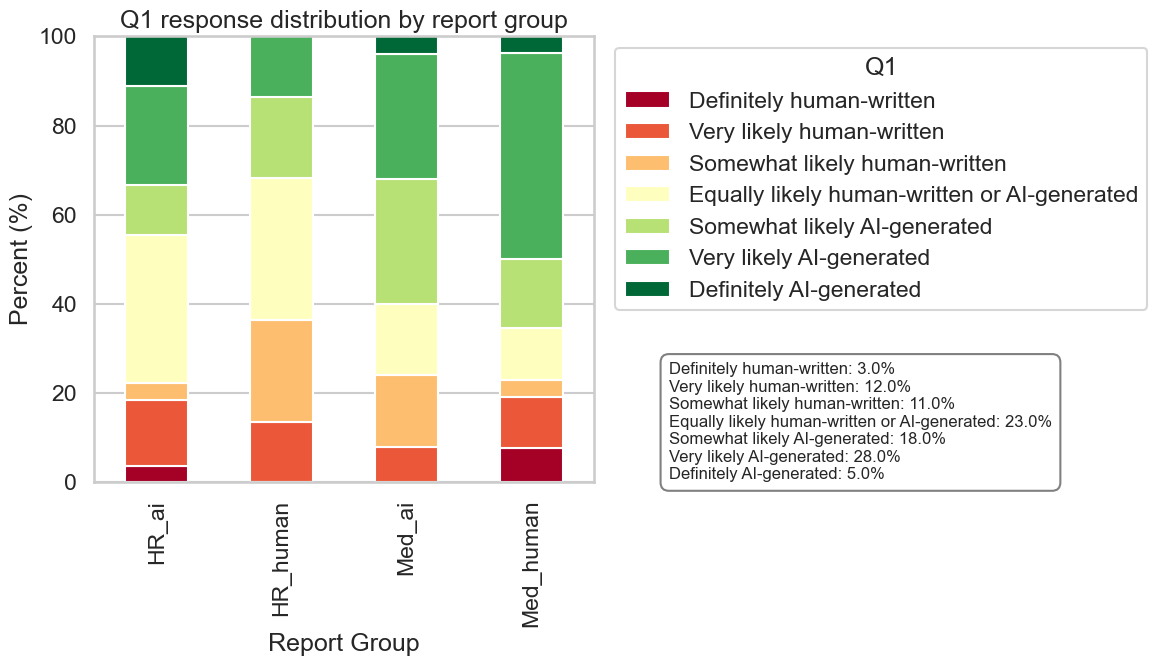

In [33]:
# 堆叠百分比条形图，确保每组总和为100%，并在右下角显示每个label的总百分比
order = likert_order
fig, ax = plt.subplots(figsize=(12, 7))

# 重新计算百分比，确保每组总和为100%
plot_df = freq.copy()
# 先pivot为宽表，缺失填0
mat = (plot_df
       .pivot(index="FL_9_DO", columns="Q1_label", values="count")
       .reindex(columns=order)
       .fillna(0))
# 计算每组总数
row_sums = mat.sum(axis=1)
# 归一化为百分比
mat_pct = mat.div(row_sums, axis=0) * 100

# 绘制堆叠条形图
mat_pct.plot(kind="bar", stacked=True, ax=ax, colormap="RdYlGn")
ax.set_ylabel("Percent (%)")
ax.set_xlabel("Report Group")
ax.set_title("Q1 response distribution by report group")
ax.legend(title="Q1", bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set_ylim(0, 100)
plt.tight_layout()

# 计算每个label的总百分比
label_totals = mat.sum(axis=0)
label_percents = label_totals / label_totals.sum() * 100

# 在图右下角显示每个label的总百分比
# 中文注释：在右下角添加文本框，显示每个Likert选项的总百分比
text_lines = [f"{label}: {pct:.1f}%" for label, pct in zip(order, label_percents)]
text_str = "\n".join(text_lines)
# 位置在图的右下角，bbox美化
ax.text(1.15, 0, text_str, transform=ax.transAxes, va="bottom", ha="left",
        fontsize=12, bbox=dict(facecolor="white", edgecolor="gray", boxstyle="round,pad=0.5"))

plt.show()

# 为什么这个图不是100%？
# 之前的代码直接用freq["pct"]，但如果某些Likert选项在某组完全没有出现，pivot后会缺失，导致总和<100%。
# 现在用count再归一化，缺失填0，确保每组总和严格为100%。


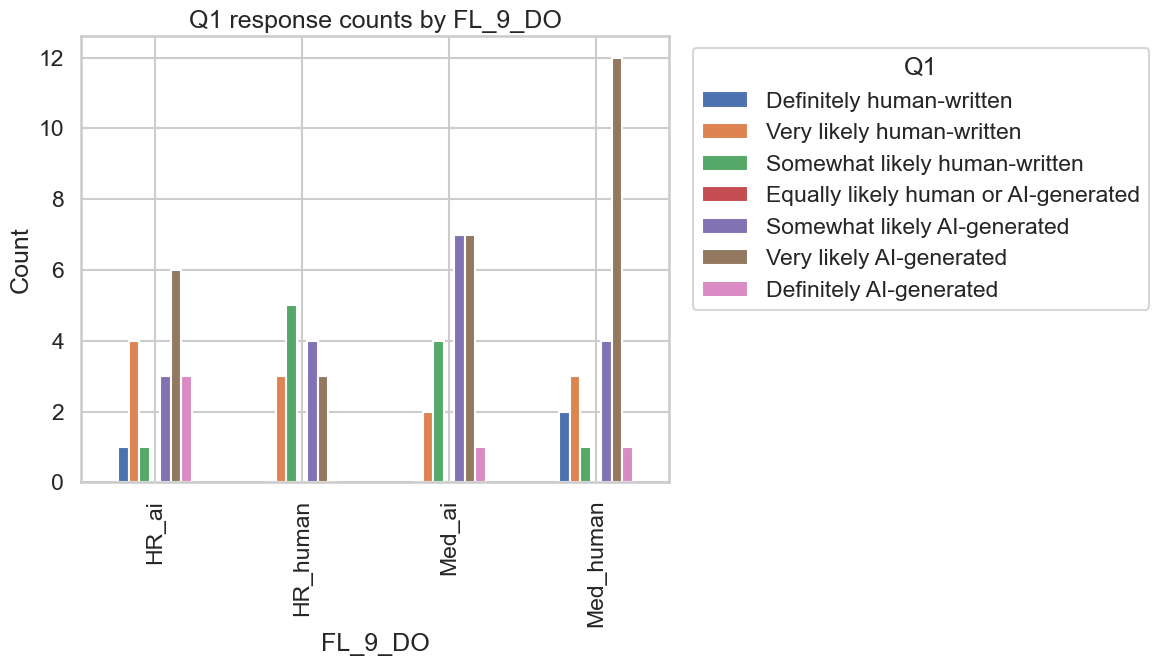

In [18]:
# Count bar chart (not stacked)
fig, ax = plt.subplots(figsize=(12, 7))
count_mat = (freq
             .pivot(index="FL_9_DO", columns="Q1_label", values="count")
             .reindex(columns=order))
count_mat.plot(kind="bar", stacked=False, ax=ax)
ax.set_ylabel("Count")
ax.set_xlabel("FL_9_DO")
ax.set_title("Q1 response counts by FL_9_DO")
ax.legend(title="Q1", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [21]:
# 描述性统计：根据上面的likert_order顺序自动生成score_map
score_map = {label: i+1 for i, label in enumerate(likert_order)}
use["Q1_score"] = use["Q1_label"].map(score_map).astype(float)  # 确保为float类型，避免category类型报错

stats = (use
         .groupby("FL_9_DO", observed=True)["Q1_score"]
         .agg(
             n=lambda s: s.notna().sum(),
             mean="mean",
             std="std"
         )
        )
# 95% 置信区间，正态近似
stats["se"] = stats["std"] / np.sqrt(stats["n"].clip(lower=1))
stats["ci95"] = 1.96 * stats["se"]
stats[["n", "mean", "ci95"]].round(3)


,n,mean,ci95
FL_9_DO,,,
FL_9 - Block Randomizer - Display Order,0,NaN,NaN
HR_ai,18,4.667,0.951
HR_human,15,3.933,0.776
Med_ai,21,4.762,0.633
Med_human,23,4.783,0.769
"{""ImportId"":""FL_9_DO""}",0,NaN,NaN


In [22]:
# Save summary outputs
out_dir = BASE_DIR / "outputs"
out_dir.mkdir(exist_ok=True)

freq.to_csv(out_dir / "q1_by_FL9_counts_pct.csv", index=False)
freq_pivot.to_csv(out_dir / "q1_by_FL9_pct_pivot.csv")
stats.to_csv(out_dir / "q1_by_FL9_stats.csv")

print("Saved to:", out_dir)


Saved to: C:\Users\zhang\OneDrive\obsdian\Made by Human\code\outputs
